In [ ]:
# pip install xgboost

# **Setup and Data Loading**

In [1]:
# Import necessary libraries
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree

# Add the parent directory ('BNetzA') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import custom modules
from models import *
from Data_Preprocessing.data_preprocessing import *

# Suppress specific warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Set pandas display option for floating-point numbers
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# Load Data
path_to_excel = "../data/EVS4_20140118_dataV9.xlsx"
df = load_data(path_to_excel, sheet_name="DatasetV9")

In [4]:
# df_test_list = [df_test, df_test_xlog, df_test_xlog_ylog, df_test_ylog, df_test_agg, df_test_agg_log, df_test_non_agg, df_test_group_agg]
# baseline, xlog, xlog ylog, ylog, agg, agg ylog, non agg, group agg
# missing: agg xlog, agg xlog ylog
# missing: non agg xlog, non agg xlog ylog, non agg ylog
# missing: group agg xlog, group agg xlog ylog, group agg ylog

In [3]:
# Define model parameters
outcome_variables = [
    "cTOTEXn", "cTOTEXn", "cTOTEXn_log", "cTOTEXn_log", 
    "cTOTEXn", "cTOTEXn_log", "cTOTEXn", "cTOTEXn"
]

names = [
    "Baseline", "XLog", "XLog YLog", "YLog", 
    "Aggregates Only", "Aggregates Only YLog", 
    "Disaggregates Only", "Aggregates N1-4 N5-7"
]

outcome_transformation = [
    "None", "None", "log", "log", 
    "None", "log", "None", "None"
]

random_states = [39, 40, 41, 42, 43]

# Define evaluation metrics columns
columns = [
    "Model", "Training RMSE", "Training MAE", "Training MAPE", 
    "Testing RMSE", "Testing MAE", "Testing MAPE"
]

# **Predictive Models**

### **Lasso Regression with Custom Data Variations**
Lasso regression is applied to datasets that vary in feature transformations, including both logarithmic and non-logarithmic outcomes. The analysis also incorporates different random seeds for data splitting, ensuring robustness across different data partitions. Results are aggregated and evaluated, focusing on deviations in performance metrics like RMSE and MAPE.


In [5]:
# Initialize storage for results, models, and variable importance (VIP) scores
lasso_results = pd.DataFrame(columns=columns)
lasso_models = []
lasso_vips = []

# Loop through each random state to prepare data and run Lasso regression
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)
    
    # Loop through each variation of the dataset
    for i in range(len(df_train_list)):
        # Perform Lasso regression and store the results
        lasso_result, lasso_model, lasso_vip = lasso_regression(
            df_train_list[i], 
            df_test_list[i], 
            outcome_variables[i], 
            f"Lasso {names[i]}", 
            outcome_transformation=outcome_transformation[i], 
            random_state=random_state
        )
        
        # Concatenate results and append models and VIPs to their respective lists
        lasso_results = pd.concat([lasso_results, lasso_result], axis=0, ignore_index=True)
        lasso_models.append(lasso_model)
        lasso_vips.append(lasso_vip)

# Convert results to numeric, ignoring the 'Model' column
lasso_results.loc[:, lasso_results.columns != 'Model'] = lasso_results.loc[:, lasso_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
lasso_results_df = lasso_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final results DataFrame
lasso_results_df


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
1,Lasso Aggregates Only,7583134.1940,4640771.0300,0.1740,17908963.3640,7210410.5920,0.1960
4,Lasso Disaggregates Only,4387758.6500,2950621.7080,0.1460,16269428.3820,7617384.2360,0.3640
3,Lasso Baseline,4451456.6160,2969861.2360,0.1460,16244300.1740,7705064.8980,0.3680
0,Lasso Aggregates N1-4 N5-7,5408350.9640,3793401.6000,0.1760,15461434.7180,7617281.6440,0.4300
7,Lasso YLog,238548674.4180,31717017.5340,0.3220,1519404205.0400,349358998.6680,0.8500
5,Lasso XLog,72088678.5860,37785655.4460,1.6920,61913800.8180,36692748.2300,2.1400


Analyzing variable importance scores across multiple iterations of Lasso models with logarithmic transformations applied to **both the features (XLog) and the target variable (YLog)** to identify stable variables that frequently appear.

In [6]:
# Select specific VIPs related to XLog YLog models
lasso_xlog_ylog_vips = [
    lasso_vips[2], 
    lasso_vips[10], 
    lasso_vips[18], 
    lasso_vips[26], 
    lasso_vips[34]
]

# Calculate the frequency of variables in the selected VIPs
lasso_xlog_ylog_frequency = variable_frequency(lasso_xlog_ylog_vips, "Lasso XLog YLog")

# Identify stable variables that appear more than 3 times
lasso_xlog_ylog_stable = lasso_xlog_ylog_frequency[
    lasso_xlog_ylog_frequency["Lasso XLog YLog"] > 3
]["Variable"].unique()

# Display the frequency data for stable variables
lasso_xlog_ylog_frequency[
    lasso_xlog_ylog_frequency["Lasso XLog YLog"] > 3
]

,Variable,Lasso XLog YLog
0,yEnergy.losses.tot,5
1,yInstalledPower.other.tot,5
2,yNet.length.excl.house.tot,5
3,yEnergy.delivered.N1357.sum,5
4,ySubstations.N4,5
5,yArea.other.N7,4
6,ySubstations.own.N4,4
7,yPeakload.max,4
8,yPeakload.injection.N6,4


Analyzing variable importance scores across multiple iterations of Lasso models with logarithmic transformations applied to **aggregated features and the target variable (YLog)** to identify stable variables that frequently appear.

In [7]:
# Select specific VIPs related to Aggregate YLog models
lasso_agg_log_vips = [
    lasso_vips[5], 
    lasso_vips[13], 
    lasso_vips[21], 
    lasso_vips[29], 
    lasso_vips[37]
]

# Calculate the frequency of variables in the selected VIPs
lasso_agg_log_frequency = variable_frequency(lasso_agg_log_vips, "Lasso Agg YLog")

# Identify stable variables that appear more than 3 times
lasso_agg_log_stable = lasso_agg_log_frequency[
    lasso_agg_log_frequency["Lasso Agg YLog"] > 3
]["Variable"].unique()

# Display the frequency data for stable variables
lasso_agg_log_frequency[
    lasso_agg_log_frequency["Lasso Agg YLog"] > 3
]


,Variable,Lasso Agg YLog
0,yEnergy.losses.tot,5
1,yNet.length.excl.house.tot,5
2,yInstalledPower.other.tot,5
3,yInstalledPower.KWKG.other.tot,5
4,yEnergy.delivered.N1357.sum,5
5,yMeters.over10MWh.RPM.tot,4
6,yInjection.tot,4
7,yEnergy.delivered.net.N67.sum,4
8,yEnergy.delivered.tot,4
9,yMeters.active.tot,4


### **Linear Regression with selected Features from Lasso**

Applying Linear Regression with Lasso feature selection across multiple dataset variations, different random states, and outcome transformations, followed by aggregating and ranking the models based on Testing MAPE.

In [8]:
# Initialize storage for Linear Regression results and models
lr_results = pd.DataFrame(columns=columns)
lr_models = []

# Loop through each random state to prepare data and run Linear Regression with Lasso feature selection
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)
    
    # Loop through each variation of the dataset
    for i in range(len(df_train_list)):
        # Perform Linear Regression with Lasso feature selection and store the results
        lr_result, lr_model = lasso_feature_selection_linear_regression(
            df_train_list[i], 
            df_test_list[i], 
            outcome_variables[i], 
            f"Linear Regression {names[i]}", 
            outcome_transformation=outcome_transformation[i], 
            random_state=random_state
        )
        
        # Concatenate results and append models to the list
        lr_results = pd.concat([lr_results, lr_result], axis=0, ignore_index=True)
        lr_models.append(lr_model)

# Convert results to numeric, ignoring the 'Model' column
lr_results.loc[:, lr_results.columns != 'Model'] = lr_results.loc[:, lr_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
lr_results_df = lr_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final results DataFrame
lr_results_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regression Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
6,Linear Regression XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
1,Linear Regression Aggregates Only,6968612.1220,4517576.9640,0.1840,16672876.6480,6854655.0280,0.2040
4,Linear Regression Disaggregates Only,3087245.3840,2234400.2060,0.1360,36085737.7800,14147798.2840,0.3700
0,Linear Regression Aggregates N1-4 N5-7,4136841.9420,3042171.1880,0.1660,15187860.5800,7560951.7200,0.3940
3,Linear Regression Baseline,3013376.3480,2182353.8140,0.1400,31826057.4580,12705211.8480,0.3940
7,Linear Regression YLog,35254376.8480,11705541.8580,0.2320,2970443916.7560,674763754.5000,1.1100
5,Linear Regression XLog,63012231.9180,37332414.5620,1.8200,84939751.7220,46865510.8120,2.8300


### **Random Forest Regression**

Conducting Random Forest regression across multiple dataset variations and random states, collecting and aggregating the results, including model performance and variable importance, and ranking the models based on Testing MAPE.


In [9]:
# Initialize storage for Random Forest results, models, and VIPs
rf_results = pd.DataFrame(columns=columns)
rf_models = []
rf_vips = []

# Loop through each random state to prepare data and run Random Forest regression
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)
    
    # Loop through each variation of the dataset
    for i in range(len(df_train_list)):
        # Perform Random Forest regression and store the results
        rf_result, rf_model, rf_vip = random_forest_regression(
            df_train_list[i], 
            df_test_list[i], 
            outcome_variables[i], 
            f"Random Forest {names[i]}", 
            outcome_transformation=outcome_transformation[i], 
            random_state=random_state
        )
        
        # Concatenate results and append models and VIPs to their respective lists
        rf_results = pd.concat([rf_results, rf_result], axis=0, ignore_index=True)
        rf_models.append(rf_model)
        rf_vips.append(rf_vip)

# Convert results to numeric, ignoring the 'Model' column
rf_results.loc[:, rf_results.columns != 'Model'] = rf_results.loc[:, rf_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
rf_results_df = rf_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final results DataFrame
rf_results_df


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
6,Random Forest XLog YLog,19134934.1460,4903620.0280,0.0600,32468675.7160,10972026.8180,0.1760
7,Random Forest YLog,20204170.5080,5140860.4460,0.0600,31763949.2860,10782847.6540,0.1780
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
0,Random Forest Aggregates N1-4 N5-7,14867863.8740,4279602.9620,0.0640,30667800.2920,9546324.8920,0.1940
1,Random Forest Aggregates Only,15751245.6360,4346582.2560,0.0720,30678835.8600,10800411.9820,0.2180
3,Random Forest Baseline,15309123.3900,4301444.3720,0.0700,31011846.2520,10879545.2560,0.2300
5,Random Forest XLog,14555804.5060,4205995.5220,0.0700,32649680.9140,11256803.3320,0.2300
4,Random Forest Disaggregates Only,17973736.4740,4643067.4300,0.0760,38131893.8420,13049602.4240,0.2900


Analyzing variable importance scores across Random Forest models with logarithmic transformations applied to aggregated features, identifying stable variables that appear more than twice.

In [10]:
# Select specific VIPs related to Random Forest Aggregates Only YLog models
rf_agg_log_vips = [
    rf_vips[5], 
    rf_vips[13], 
    rf_vips[21], 
    rf_vips[29], 
    rf_vips[37]
]

# Calculate the frequency of variables in the selected VIPs
rf_agg_log_frequency = variable_frequency(rf_agg_log_vips, "Random Forest Aggregates Only YLog")

# Identify stable variables that appear more than 2 times
rf_agg_log_stable = rf_agg_log_frequency[
    rf_agg_log_frequency["Random Forest Aggregates Only YLog"] > 2
]["Variable"].unique()

# Display the frequency data for stable variables
rf_agg_log_frequency[
    rf_agg_log_frequency["Random Forest Aggregates Only YLog"] > 2
]

,Variable,Random Forest Aggregates Only YLog
0,yEnergy.delivered.net.N5to7.sum,5
1,yEnergy.delivered.tot,5
2,yMeters.all.tot,5
3,yEnergy.delivered.net.tot,5
4,yTransformers.tot,5
5,yEnergy.losses.tot,5
6,yEnergy.delivered.N1357.sum,5
7,yMeters.read.noncp.sum,5
8,yMeters.active.tot,5
9,yInjection.tot,5


Aggregating and converting Random Forest results to numeric values, then computing the mean for each model and sorting by Testing MAPE.

In [11]:
# Convert results to numeric, ignoring the 'Model' column
rf_results.loc[:, rf_results.columns != 'Model'] = rf_results.loc[:, rf_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
rf_results_final_df = rf_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final aggregated and sorted results
rf_results_final_df

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
6,Random Forest XLog YLog,19134934.1460,4903620.0280,0.0600,32468675.7160,10972026.8180,0.1760
7,Random Forest YLog,20204170.5080,5140860.4460,0.0600,31763949.2860,10782847.6540,0.1780
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
0,Random Forest Aggregates N1-4 N5-7,14867863.8740,4279602.9620,0.0640,30667800.2920,9546324.8920,0.1940
1,Random Forest Aggregates Only,15751245.6360,4346582.2560,0.0720,30678835.8600,10800411.9820,0.2180
3,Random Forest Baseline,15309123.3900,4301444.3720,0.0700,31011846.2520,10879545.2560,0.2300
5,Random Forest XLog,14555804.5060,4205995.5220,0.0700,32649680.9140,11256803.3320,0.2300
4,Random Forest Disaggregates Only,17973736.4740,4643067.4300,0.0760,38131893.8420,13049602.4240,0.2900


### **Decision Tree Regression**

Running Decision Tree regression across multiple dataset variations and random states, aggregating the results, and ranking models based on Testing MAPE.

In [12]:
# Initialize storage for Decision Tree results, models, and VIPs
dt_results = pd.DataFrame(columns=columns)
dt_models = []
dt_vips = []

# Loop through each random state to prepare data and run Decision Tree regression
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)
    
    # Loop through each variation of the dataset
    for i in range(len(df_train_list)):
        # Perform Decision Tree regression and store the results
        dt_result, dt_model, dt_vip = decision_tree_regression(
            df_train_list[i], 
            df_test_list[i], 
            outcome_variables[i], 
            f"Decision Tree {names[i]}", 
            outcome_transformation=outcome_transformation[i], 
            random_state=random_state
        )
        
        # Concatenate results and append models and VIPs to their respective lists
        dt_results = pd.concat([dt_results, dt_result], axis=0, ignore_index=True)
        dt_models.append(dt_model)
        dt_vips.append(dt_vip)

# Convert results to numeric, ignoring the 'Model' column
dt_results.loc[:, dt_results.columns != 'Model'] = dt_results.loc[:, dt_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
dt_results_df = dt_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final results DataFrame
dt_results_df

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
3,Decision Tree Baseline,14732790.0080,3109712.3300,0.0360,30017159.0520,11046364.9360,0.2160
5,Decision Tree XLog,14653850.4780,3098652.2000,0.0340,32852911.8800,11860650.1600,0.2180
4,Decision Tree Disaggregates Only,5082944.6140,1144066.4880,0.0240,30410442.1560,10751974.8340,0.2220
0,Decision Tree Aggregates N1-4 N5-7,11521225.3520,2896062.8840,0.0400,52923467.0620,17539637.4080,0.2420
7,Decision Tree YLog,28298985.5660,6019625.5460,0.0560,53822603.4780,17095497.8600,0.2440
2,Decision Tree Aggregates Only YLog,29351417.3700,6708681.1120,0.0640,66000628.9300,21318852.9340,0.2460
1,Decision Tree Aggregates Only,16350463.3160,4012843.7580,0.0600,34796633.5400,12521636.3640,0.2580
6,Decision Tree XLog YLog,33598548.2400,7324825.7300,0.0620,87157855.3420,28943622.3480,0.2860


Analyzing variable importance scores from the Decision Tree Baseline models to identify stable variables that appear more than once.

In [14]:
# Select specific VIPs related to Decision Tree Baseline models
dt_baseline_vips = [
    dt_vips[0], 
    dt_vips[8], 
    dt_vips[16], 
    dt_vips[24], 
    dt_vips[32]
]

# Calculate the frequency of variables in the selected VIPs
dt_baseline_frequency = variable_frequency(dt_baseline_vips, "Decision Tree Baseline")

# Identify stable variables that appear more than once
dt_baseline_stable = dt_baseline_frequency[
    dt_baseline_frequency["Decision Tree Baseline"] > 1
]["Variable"].unique()

# Display the frequency data for stable variables
dt_baseline_frequency[
    dt_baseline_frequency["Decision Tree Baseline"] > 1
]

,Variable,Decision Tree Baseline
0,yEnergy.delivered.N7,3
1,yPeakload.injection.max,3
2,yPeakload.injection.N6,2
3,yEnergy.delivered.net.N5to7.sum,2
4,yTransformers.N6,2
5,yEnergy.delivered.N5,2
6,yPeakload.injection.N3,2
7,rInjection.generation.per.point.N6,2
8,yPeakload.injection.N4,2


### **Cluster-Based Modeling**

Performing Cluster-Based Modeling on selected dataset variations, with a focus on Baseline and YLog transformations, aggregating the results, and ranking models based on Testing MAPE.

In [15]:
# Initialize storage for Cluster-Based Modeling results and models
cluster_results = pd.DataFrame(columns=columns)
cluster_models_c0 = []
cluster_models_c1 = []

# Define specific outcome variables and transformations for Cluster-Based Modeling
outcome_variables_cbm = ["cTOTEXn", "cTOTEXn_log"]
names_cbm = ["Baseline", "YLog"]
outcome_transformation_cbm = ["None", "log"]
indices = [0, 3]

# Loop through each random state to prepare data and run Cluster-Based Modeling
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)
    
    # Loop through specified indices for Cluster-Based Modeling
    for i in range(len(outcome_transformation_cbm)):
        # Perform Cluster-Based Modeling and store the results
        cluster_result, model_c0, model_c1 = cluster_based_modeling(
            df_train_list[indices[i]], 
            df_test_list[indices[i]], 
            outcome_variables_cbm[i], 
            f"Cluster-Based Modeling {names_cbm[i]}", 
            outcome_transformation=outcome_transformation_cbm[i], 
            random_state=random_state
        )
        
        # Concatenate results and append models to their respective lists
        cluster_results = pd.concat([cluster_results, cluster_result], axis=0, ignore_index=True)
        cluster_models_c0.append(model_c0)
        cluster_models_c1.append(model_c1)

# Convert results to numeric, ignoring the 'Model' column
cluster_results.loc[:, cluster_results.columns != 'Model'] = cluster_results.loc[:, cluster_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
cluster_results_df = cluster_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final results DataFrame
cluster_results_df


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Cluster-Based Modeling Baseline_Random Forest_...,4754003.2400,2640416.4700,0.0900,13571233.7900,5795520.6600,0.1300
4,Cluster-Based Modeling YLog_Random Forest_Rand...,13595760.4500,4069552.6200,0.0600,97656319.3500,25657539.5700,0.1800
3,Cluster-Based Modeling YLog_Lasso_Random Forest,19109230.9025,5332817.5150,0.1075,17904496.4100,8284606.6000,0.2075
0,Cluster-Based Modeling Baseline_Lasso_Lasso,3557628.1850,2283322.3950,0.1000,17393501.4950,8130304.4800,0.2100
1,Cluster-Based Modeling Baseline_Lasso_Random F...,17257074.4100,4730757.6250,0.0950,8629992.1350,4629656.3850,0.2700


Due to very unstable best performing model, this approach is not anymore feasible for the use case. In 10 different runs, 5 different models have emerged.

# **Summary Results**

### **Evaluation Metrics**

Combining and sorting the results from Lasso, Linear Regression, Random Forest, and Decision Tree models, ranked by Testing MAPE and Testing RMSE.

In [20]:
# Combine results from Lasso, Linear Regression, Random Forest, and Decision Tree models
combined_all = pd.concat([lasso_results_df, lr_results_df, rf_results_df, dt_results_df], axis=0)

# Sort the combined results by 'Testing MAPE' and 'Testing RMSE' in ascending order
combined_all_sorted = combined_all.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

# Display the sorted combined results
combined_all_sorted

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regression Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
6,Linear Regression XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
6,Random Forest XLog YLog,19134934.1460,4903620.0280,0.0600,32468675.7160,10972026.8180,0.1760
7,Random Forest YLog,20204170.5080,5140860.4460,0.0600,31763949.2860,10782847.6540,0.1780
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
0,Random Forest Aggregates N1-4 N5-7,14867863.8740,4279602.9620,0.0640,30667800.2920,9546324.8920,0.1940
1,Lasso Aggregates Only,7583134.1940,4640771.0300,0.1740,17908963.3640,7210410.5920,0.1960
1,Linear Regression Aggregates Only,6968612.1220,4517576.9640,0.1840,16672876.6480,6854655.0280,0.2040


Selecting and sorting the best models from Lasso, Linear Regression, Random Forest, and Decision Tree for further analysis, ranked by Testing MAPE and Testing RMSE.

In [21]:
# Select the best models for further analysis
best_lasso = lasso_results_df[lasso_results_df["Model"].isin(["Lasso Aggregates Only YLog", "Lasso XLog YLog"])]
best_lr = lr_results_df[lr_results_df["Model"].isin(["Linear Regression XLog YLog", "Linear Regression Aggregates Only YLog"])]
best_rf = rf_results_df[rf_results_df["Model"].isin(["Random Forest Aggregates Only YLog"])]
best_dt = dt_results_df[dt_results_df["Model"].isin(["Decision Tree Baseline"])]

# Combine the selected best models
combined_best = pd.concat([best_lasso, best_lr, best_rf, best_dt], axis=0)

# Sort the combined best models by 'Testing MAPE' and 'Testing RMSE' in ascending order
combined_best_sorted = combined_best.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

# Display the sorted combined best models
combined_best_sorted

,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
2,Linear Regression Aggregates Only YLog,15662174.8340,6470256.8480,0.1200,10119945.7280,5421080.0660,0.1380
2,Lasso Aggregates Only YLog,19509173.4220,7579512.9960,0.1240,11268863.2300,5562088.2800,0.1400
6,Lasso XLog YLog,20123969.0380,7400527.3200,0.1220,15132882.6880,6881961.5580,0.1480
6,Linear Regression XLog YLog,15695991.1580,6450477.1820,0.1160,14841106.8660,6892647.4480,0.1500
2,Random Forest Aggregates Only YLog,19972940.5420,4928059.3220,0.0600,31137574.2240,10251750.1800,0.1860
3,Decision Tree Baseline,14732790.0080,3109712.3300,0.0360,30017159.0520,11046364.9360,0.2160


### **Variable Importance**

Performing an outer join on the 'Variable' column across different models' frequency data, summing their occurrences, and sorting the top 20 variables by total frequency.


In [22]:
# Perform an outer join on the 'Variable' column across different frequency DataFrames
frequency_df = pd.merge(lasso_xlog_ylog_frequency, lasso_agg_log_frequency, on='Variable', how='outer')
frequency_df = pd.merge(frequency_df, dt_baseline_frequency, on='Variable', how='outer')
frequency_df = pd.merge(frequency_df, rf_agg_log_frequency, on='Variable', how='outer')

# Replace NaN values with 0 to indicate that the variable was not present in that model
frequency_df.fillna(0, inplace=True)

# Calculate the total frequency across all models
columns_to_sum = frequency_df.columns.difference(['Variable'])
frequency_df['Total'] = frequency_df[columns_to_sum].sum(axis=1)

# Rename columns for clarity
frequency_df.columns = [
    'Variable', 'Lasso XLog YLog', 'Linear Regression Agg YLog', 
    'Decision Tree Baseline', 'Random Forest Aggregates Only YLog', 
    'Total'
]

# Sort the DataFrame by 'Total' in descending order and display the top 20 variables
frequency_df_sorted = frequency_df.sort_values(by="Total", ascending=False).head(20)

# Display the sorted frequency DataFrame
frequency_df_sorted

,Variable,Lasso XLog YLog,Linear Regression Agg YLog,Decision Tree Baseline,Random Forest Aggregates Only YLog,Total
0,yEnergy.losses.tot,5.0000,5.0000,1.0000,5.0000,16.0000
3,yEnergy.delivered.N1357.sum,5.0000,5.0000,0.0000,5.0000,15.0000
18,yEnergy.delivered.tot,2.0000,4.0000,1.0000,5.0000,12.0000
2,yNet.length.excl.house.tot,5.0000,5.0000,0.0000,1.0000,11.0000
40,yMeters.active.tot,1.0000,4.0000,0.0000,5.0000,10.0000
16,yMeters.over10MWh.RPM.tot,2.0000,4.0000,0.0000,4.0000,10.0000
1,yInstalledPower.other.tot,5.0000,5.0000,0.0000,0.0000,10.0000
43,yInjection.tot,0.0000,4.0000,0.0000,5.0000,9.0000
44,yEnergy.delivered.net.N67.sum,0.0000,4.0000,0.0000,5.0000,9.0000
15,yInstalledPower.KWKG.other.tot,3.0000,5.0000,0.0000,0.0000,8.0000


# **Final Best Models with Robust Variables and Interpretation**

## **Lasso**

### **Lasso Regression on Xlog Ylog**

Running final Lasso regression on **XLog YLog** models using stable variables, aggregating the results, and ranking models based on Testing MAPE.

In [23]:
# Initialize storage for final Lasso XLog YLog results, models, and VIPs
final_lasso_xy_log_results = pd.DataFrame(columns=columns)
final_lasso_xy_log_models = []
final_lasso_xy_log_vips = []

# Loop through each random state to prepare data and run final Lasso regression on XLog YLog models
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the XLog YLog model (index 2)
    i = 2
    selected_columns = list(lasso_xlog_ylog_stable) + [outcome_variables[i]]

    # Perform Lasso regression using the stable variables and store the results
    lasso_result, lasso_model, lasso_vip = lasso_regression(
        df_train_list[i][selected_columns], 
        df_test_list[i][selected_columns], 
        outcome_variables[i], 
        f"Lasso {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    
    # Concatenate results and append models and VIPs to their respective lists
    final_lasso_xy_log_results = pd.concat([final_lasso_xy_log_results, lasso_result], axis=0, ignore_index=True)
    final_lasso_xy_log_models.append(lasso_model)
    final_lasso_xy_log_vips.append(lasso_vip)

# Convert results to numeric, ignoring the 'Model' column
final_lasso_xy_log_results.loc[:, final_lasso_xy_log_results.columns != 'Model'] = final_lasso_xy_log_results.loc[:, final_lasso_xy_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_lasso_xy_log_results_df = final_lasso_xy_log_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Lasso XLog YLog results DataFrame
final_lasso_xy_log_results_df


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Lasso XLog YLog,18722158.0020,7340288.0920,0.1260,9596175.5220,4991840.8700,0.1280


Retrieving the regularization parameter (`alpha_`) used by the first Lasso model in the final XLog YLog analysis.

In [25]:
final_lasso_xy_log_models[0].alpha_

0.010131883775070828

Calculating and displaying the unstandardized coefficients for the final Lasso XLog YLog model

In [27]:
# Select stable variables and the target column for the Lasso XLog YLog model
selected_columns = list(lasso_xlog_ylog_stable) + ["cTOTEXn_log"]
df_train = df_train_list[2][selected_columns].copy()

# Separate features from the target variable
X_log = df_train.drop(columns=["cTOTEXn_log"])

# Standardize the features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Get the standardized coefficients from the Lasso model
standardized_coefficients = final_lasso_xy_log_models[0].coef_

# Unstandardize the coefficients by adjusting for the scaling applied to the features
unstandardized_coefficients = standardized_coefficients / scaler.scale_

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})

# Display the feature coefficients
feature_coefficients

,Feature,Unstandardized Coefficient
0,yEnergy.losses.tot,0.3489
1,yInstalledPower.other.tot,0.0097
2,yNet.length.excl.house.tot,0.0977
3,yEnergy.delivered.N1357.sum,0.3117
4,ySubstations.N4,0.0297
5,yArea.other.N7,0.0406
6,ySubstations.own.N4,0.0011
7,yPeakload.max,0.0152
8,yPeakload.injection.N6,0.1015


All of the unstandardized coefficients are positive, confirming that they have the expected sign. These coefficients adhere to the monotonicity constraints of the model.

Using the final Lasso XLog YLog model to make predictions on both training and testing sets, then calculating the percentage deviation between the actual and predicted values.


In [28]:
# Make predictions using the final Lasso XLog YLog model on the training and testing sets
y_train, y_train_pred, y_test, y_test_pred = model_predict(
    final_lasso_xy_log_models[0], 
    df_train_list[2][selected_columns], 
    df_test_list[2][selected_columns], 
    "cTOTEXn_log", 
    outcome_transformation="log", 
    random_state=random_state, 
    scaling=True
)

# Calculate the percentage deviation between actual and predicted values for both training and testing sets
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)


,Actual,Predicted,Percentage Deviation
12,15971573.2319,23079841.9695,44.5058
18,13596298.6017,16842806.5966,23.8779
11,74969320.0894,89432329.5826,19.2919
2,19013109.2716,16084690.5681,15.4021
8,34079062.8130,38932528.0464,14.2418
0,28773210.2541,24859971.4233,13.6003
3,10153881.8875,11509458.7880,13.3503
9,46533707.1645,52640644.8223,13.1237
14,7527965.6254,8440724.2329,12.1249
13,13164584.1383,11618200.3459,11.7465


The model's predictions show varying levels of accuracy, with percentage deviations ranging from as low as 0.46% to as high as 44.51%. This indicates that while the model performs well in most cases, there are a few instances where the predictions significantly deviate from the actual values.

### **Lasso Regression on only Ylog**

Running final Lasso regression on Aggregates **Only YLog** models using stable variables, aggregating the results, and ranking models based on Testing MAPE.

In [29]:
# Initialize storage for final Lasso Aggregates Only YLog results, models, and VIPs
final_lasso_agg_log_results = pd.DataFrame(columns=columns)
final_lasso_agg_log_models = []
final_lasso_agg_log_vips = []

# Loop through each random state to prepare data and run final Lasso regression on Aggregates Only YLog models
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the Aggregates Only YLog model (index 5)
    i = 5
    selected_columns = list(lasso_agg_log_stable) + [outcome_variables[i]]

    # Perform Lasso regression using the stable variables and store the results
    lasso_result, lasso_model, lasso_vip = lasso_regression(
        df_train_list[i][selected_columns], 
        df_test_list[i][selected_columns], 
        outcome_variables[i], 
        f"Lasso {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    
    # Concatenate results and append models and VIPs to their respective lists
    final_lasso_agg_log_results = pd.concat([final_lasso_agg_log_results, lasso_result], axis=0, ignore_index=True)
    final_lasso_agg_log_models.append(lasso_model)
    final_lasso_agg_log_vips.append(lasso_vip)

# Convert results to numeric, ignoring the 'Model' column
final_lasso_agg_log_results.loc[:, final_lasso_agg_log_results.columns != 'Model'] = final_lasso_agg_log_results.loc[:, final_lasso_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_lasso_agg_log_results_df = final_lasso_agg_log_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Lasso Aggregates Only YLog results DataFrame
final_lasso_agg_log_results_df


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Lasso Aggregates Only YLog,17808874.6440,7095395.6540,0.1260,10334888.5000,5419544.5340,0.1380


Retrieving the regularization parameter (`alpha_`) used by the first Lasso model in the final Aggregates Only YLog analysis.

In [32]:
# Retrieve the alpha value (regularization strength) of the first Lasso model in the final Aggregates Only YLog models list
final_lasso_agg_log_models[0].alpha_

0.007664398514886828

Calculating and displaying the unstandardized coefficients for the final Lasso Aggregates Only YLog model.

In [33]:
# Select stable variables and the target column for the Lasso Aggregates Only YLog model
selected_columns = list(lasso_agg_log_stable) + ["cTOTEXn_log"]
df_train = df_train_list[5][selected_columns].copy()

# Separate features from the target variable
X_log = df_train.drop(columns=["cTOTEXn_log"])

# Standardize the features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Get the standardized coefficients from the Lasso model
standardized_coefficients = final_lasso_agg_log_models[0].coef_

# Unstandardize the coefficients by adjusting for the scaling applied to the features
unstandardized_coefficients = standardized_coefficients / scaler.scale_

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})

# Display the feature coefficients
feature_coefficients

,Feature,Unstandardized Coefficient
0,yEnergy.losses.tot,0.3540
1,yNet.length.excl.house.tot,0.1093
2,yInstalledPower.other.tot,0.0101
3,yInstalledPower.KWKG.other.tot,0.0111
4,yEnergy.delivered.N1357.sum,0.3401
5,yMeters.over10MWh.RPM.tot,0.0000
6,yInjection.tot,0.0145
7,yEnergy.delivered.net.N67.sum,0.0343
8,yEnergy.delivered.tot,0.0014
9,yMeters.active.tot,0.0344


The unstandardized coefficients reveal that the features `yEnergy.losses.tot` and `yEnergy.delivered.N1357.sum` have the most significant positive influence on the target variable, similar to the results from the XLog YLog model. However, some features, like `yMeters.over10MWh.RPM.tot`, continue to show negligible influence with a coefficient close to zero. All coefficients adhere to the expected sign and monotonicity constraints, consistent with the findings from the previous model.

Using the final Lasso Aggregates Only YLog model to make predictions on both training and testing sets, followed by calculating the percentage deviation between actual and predicted values to assess the model's performance.

In [34]:
# Make predictions using the final Lasso Aggregates Only YLog model on the training and testing sets
y_train, y_train_pred, y_test, y_test_pred = model_predict(
    final_lasso_agg_log_models[0], 
    df_train_list[5][selected_columns], 
    df_test_list[5][selected_columns], 
    "cTOTEXn_log", 
    outcome_transformation="log", 
    random_state=random_state, 
    scaling=True
)

# Calculate the percentage deviation between actual and predicted values for both training and testing sets
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)

,Actual,Predicted,Percentage Deviation
12,15971573.2319,21777770.8647,36.3533
18,13596298.6017,16854975.4549,23.9674
11,74969320.0894,91282737.9571,21.7601
2,19013109.2716,15240090.0308,19.8443
9,46533707.1645,54245172.5551,16.5718
8,34079062.8130,39071066.0027,14.6483
3,10153881.8875,11639836.6576,14.6344
15,1432415.0264,1230916.0951,14.0671
5,9892128.0516,11270180.8457,13.9308
0,28773210.2541,25813359.4116,10.2868


The percentage deviations for the Aggregates Only YLog model are similar to those of the XLog YLog model, with both models demonstrating consistent performance. There is no significant difference between the two models in terms of predictive accuracy.

## **Linear Regression**

### **Linear Regression on XLog YLog Model**

Running final Linear Regression on the XLog YLog model with Lasso-selected features, aggregating the results, and ranking the models based on Testing MAPE.


In [35]:
# Initialize storage for final Linear Regression XLog YLog results and models
final_lr_xy_log_results = pd.DataFrame(columns=columns)
final_lr_xy_log_models = []

# Loop through each random state to prepare data and run Linear Regression with Lasso feature selection
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the XLog YLog model (index 2)
    i = 2
    selected_columns = list(lasso_xlog_ylog_stable) + [outcome_variables[i]]

    # Perform Linear Regression using Lasso-selected features and store the results
    lr_result, lr_model = lasso_feature_selection_linear_regression(
        df_train_list[i][selected_columns], 
        df_test_list[i][selected_columns], 
        outcome_variables[i], 
        f"Linear Regression {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    
    # Concatenate results and append models to the list
    final_lr_xy_log_results = pd.concat([final_lr_xy_log_results, lr_result], axis=0, ignore_index=True)
    final_lr_xy_log_models.append(lr_model)

# Convert results to numeric, ignoring the 'Model' column
final_lr_xy_log_results.loc[:, final_lr_xy_log_results.columns != 'Model'] = final_lr_xy_log_results.loc[:, final_lr_xy_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_lr_xy_log_results_df = final_lr_xy_log_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Linear Regression XLog YLog results DataFrame
final_lr_xy_log_results_df


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression XLog YLog,17041001.7740,7086153.0540,0.1220,11235320.2080,5487740.7340,0.1260


In [36]:
# Generate and display the summary of the first Linear Regression XLog YLog model
final_lr_xy_log_models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cTOTEXn_log   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1304.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):          1.21e-147
Time:                        16:42:44   Log-Likelihood:                 84.419
No. Observations:                 174   AIC:                            -148.8
Df Residuals:                     164   BIC:                            -117.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          16.9784      0.012   1459.692      0.000      16.955      17.001
yEnergy.losses.tot              0.4616      0.065      7.145      0.000       0.334       0.589
yInstalledPower.other.tot       0.0530      0.014      3.873      0.000       0.026       0.080
yNet.length.excl.house.tot      0.1260      0.048      2.620      0.010       0.031       0.221
yEnergy.delivered.N1357.sum     0.4289      0.089      4.820      0.000       0.253       0.605
ySubstations.N4                -0.2030      1.349     -0.150      0.881      -2.867       2.461
yArea.other.N7                  0.0424      0.030      1.405      0.162      -0.017       0.102
ySubstations.own.N4             0.2562      1.350      0.190      0.850      -2.408       2.921
yPeakload.max                   0.0290      0.077      0.377      0.706      -0.123       0.181
yPeakload.injection.N6          0.1525      0.024      6.350      0.000       0.105       0.200
==============================================================================
Omnibus:                        1.788   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.854
Skew:                          -0.210   Prob(JB):                        0.396
Kurtosis:                       2.720   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS regression results indicate a high degree of explanatory power, with an R-squared of 0.986, meaning that 98.6% of the variance in the log-transformed target variable (`cTOTEXn_log`) is explained by the model. Significant predictors include `yEnergy.losses.tot`, `yInstalledPower.other.tot`, and `yEnergy.delivered.N1357.sum`, all with p-values less than 0.01. However, some variables like `ySubstations.N4` and `ySubstations.own.N4` show non-significant effects, with high p-values and coefficients near zero, suggesting they may not be as influential in this model.

Calculating and displaying the unstandardized coefficients for the final Linear Regression XLog YLog model. The coefficients have been adjusted to account for feature scaling, with the intercept also corrected to reflect the original scale of the features.

In [37]:
# Select stable variables and the target column for the Linear Regression XLog YLog model
selected_columns = list(lasso_xlog_ylog_stable) + ["cTOTEXn_log"]
df_train = df_train_list[2][selected_columns].copy()

# Separate features from the target variable
X_log = df_train.drop(columns=["cTOTEXn_log"])

# Standardize the log-transformed features
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

# Add a constant to the model (for the intercept)
X_log_scaled_with_const = sm.add_constant(X_log_scaled)

# Get the standardized coefficients including the intercept
standardized_coefficients = final_lr_xy_log_models[0].params

# Unstandardize the coefficients (excluding the intercept)
unstandardized_coefficients = standardized_coefficients[1:] / scaler.scale_

# Adjust the intercept to account for unstandardization
unstandardized_intercept = standardized_coefficients[0] - (scaler.mean_ / scaler.scale_).dot(standardized_coefficients[1:])

# Create a DataFrame to map feature names to their unstandardized coefficients
feature_coefficients = pd.DataFrame({
    "Feature": X_log.columns,
    "Unstandardized Coefficient": unstandardized_coefficients
})

# Display the DataFrame
feature_coefficients


,Feature,Unstandardized Coefficient
yEnergy.losses.tot,yEnergy.losses.tot,0.3420
yInstalledPower.other.tot,yInstalledPower.other.tot,0.0109
yNet.length.excl.house.tot,yNet.length.excl.house.tot,0.0951
yEnergy.delivered.N1357.sum,yEnergy.delivered.N1357.sum,0.3094
ySubstations.N4,ySubstations.N4,-0.1290
yArea.other.N7,yArea.other.N7,0.0444
ySubstations.own.N4,ySubstations.own.N4,0.1631
yPeakload.max,yPeakload.max,0.0226
yPeakload.injection.N6,yPeakload.injection.N6,0.1069


The unstandardized coefficients for the final Linear Regression XLog YLog model indicate that `yEnergy.losses.tot` and `yEnergy.delivered.N1357.sum` continue to have the most significant positive influence on the target variable, with coefficients of 0.3420 and 0.3094, respectively. The negative coefficient for `ySubstations.N4` suggests a slight inverse relationship with the target variable. These coefficients, adjusted for feature scaling, align closely with the findings from the Lasso model, further confirming the importance of these features.

### **Linear Regression on Only YLog Model**

Running final Linear Regression on the Aggregates Only YLog model with Lasso-selected features, aggregating the results, and ranking the models based on Testing MAPE.

In [38]:
# Initialize storage for final Linear Regression Aggregates Only YLog results and models
final_lr_agg_log_results = pd.DataFrame(columns=columns)
final_lr_agg_log_models = []
final_lr_agg_log_vips = []

# Loop through each random state to prepare data and run Linear Regression with Lasso feature selection
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the Aggregates Only YLog model (index 5)
    i = 5
    selected_columns = list(lasso_agg_log_stable) + [outcome_variables[i]]

    # Perform Linear Regression using Lasso-selected features and store the results
    lr_result, lr_model = lasso_feature_selection_linear_regression(
        df_train_list[i][selected_columns], 
        df_test_list[i][selected_columns], 
        outcome_variables[i], 
        f"Linear Regression {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    
    # Concatenate results and append models to the list
    final_lr_agg_log_results = pd.concat([final_lr_agg_log_results, lr_result], axis=0, ignore_index=True)
    final_lr_agg_log_models.append(lr_model)

# Convert results to numeric, ignoring the 'Model' column
final_lr_agg_log_results.loc[:, final_lr_agg_log_results.columns != 'Model'] = final_lr_agg_log_results.loc[:, final_lr_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_lr_agg_log_results_df = final_lr_agg_log_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Linear Regression Aggregates Only YLog results DataFrame
final_lr_agg_log_results_df


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression Aggregates Only YLog,16014603.3220,6681713.6860,0.1240,10090748.0360,5363045.3520,0.1320


In [39]:
# Generate and display the summary of the first Linear Regression Aggregates Only YLog model
final_lr_agg_log_models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cTOTEXn_log   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1025.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):          1.44e-143
Time:                        16:51:18   Log-Likelihood:                 82.043
No. Observations:                 174   AIC:                            -140.1
Df Residuals:                     162   BIC:                            -102.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               16.9784      0.012   1431.093      0.000      16.955      17.002
yEnergy.losses.tot                   0.4717      0.068      6.916      0.000       0.337       0.606
yNet.length.excl.house.tot           0.1466      0.064      2.279      0.024       0.020       0.274
yInstalledPower.other.tot            0.0556      0.015      3.829      0.000       0.027       0.084
yInstalledPower.KWKG.other.tot       0.0234      0.025      0.950      0.344      -0.025       0.072
yEnergy.delivered.N1357.sum          0.5173      0.126      4.106      0.000       0.269       0.766
yInjection.tot                      26.7199     22.760      1.174      0.242     -18.225      71.664
yEnergy.delivered.net.N67.sum        0.0706      0.026      2.730      0.007       0.020       0.122
yEnergy.delivered.tot              -26.7422     22.772     -1.174      0.242     -71.711      18.226
yMeters.active.tot                   0.0545      0.032      1.720      0.087      -0.008       0.117
ySubstations.own.tot                 0.0261      0.066      0.398      0.691      -0.103       0.155
yPeakload.from.higher.nonsim.sum     0.0180      0.019      0.956      0.340      -0.019       0.055
==============================================================================
Omnibus:                        1.318   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.403
Skew:                          -0.196   Prob(JB):                        0.496
Kurtosis:                       2.802   Cond. No.                     7.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The OLS regression results for the Aggregates Only YLog model indicate a high R-squared of 0.986, showing that 98.6% of the variance in the log-transformed target variable (`cTOTEXn_log`) is explained by the model. Significant predictors include `yEnergy.losses.tot`, `yNet.length.excl.house.tot`, and `yEnergy.delivered.N1357.sum`, with p-values less than 0.05. However, the presence of negative coefficients, such as for `yEnergy.delivered.tot`, suggests that the monotonicity constraints are not fulfilled. To address this, Non-negative Least Squares (NNLS) could be considered to enforce non-negative coefficients. Additionally, the condition number of 7.71e+03 indicates potential multicollinearity issues.

## **Random Forest**

Running final Random Forest regression on the Aggregates Only YLog model with additional placeholder features to accommodate the model's max_features setting. The results are aggregated and models are ranked based on Testing MAPE.

In [40]:
# Initialize storage for final Random Forest Aggregates Only YLog results, models, and VIPs
final_rf_agg_log_results = pd.DataFrame(columns=columns)
final_rf_agg_log_models = []
final_rf_agg_log_vips = []

# Loop through each random state to prepare data and run Random Forest regression
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the Aggregates Only YLog model (index 5)
    i = 5
    selected_columns = list(rf_agg_log_stable) + [outcome_variables[i]]
    
    # Due to max_features set in the model definition, fill up blank columns
    df_train = df_train_list[i].copy()[selected_columns]
    df_test = df_test_list[i].copy()[selected_columns]
    
    for index in range(4):
        df_train[f'empty_{index+1}'] = 0
        df_test[f'empty_{index+1}'] = 0
    
    # Perform Random Forest regression and store the results
    rf_result, rf_model, rf_vip = random_forest_regression(
        df_train, 
        df_test, 
        outcome_variables[i], 
        f"Random Forest {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    
    # Concatenate results and append models and VIPs to their respective lists
    final_rf_agg_log_results = pd.concat([final_rf_agg_log_results, rf_result], axis=0, ignore_index=True)
    final_rf_agg_log_models.append(rf_model)
    final_rf_agg_log_vips.append(rf_vip)

# Convert results to numeric, ignoring the 'Model' column
final_rf_agg_log_results.loc[:, final_rf_agg_log_results.columns != 'Model'] = final_rf_agg_log_results.loc[:, final_rf_agg_log_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_rf_agg_log_results_df = final_rf_agg_log_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Random Forest Aggregates Only YLog results DataFrame
final_rf_agg_log_results_df


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Random Forest Aggregates Only YLog,16906286.3260,4400815.3320,0.0600,29728127.4380,10183473.8060,0.1800


In [41]:
# Retrieve and display the parameters of the first Random Forest Aggregates Only YLog model
final_rf_agg_log_models[0].get_params()

{'memory': None,
 'steps': [('feature_selection',
   SelectFromModel(estimator=RandomForestRegressor(random_state=39),
                   max_features=20)),
  ('rf', RandomForestRegressor(max_depth=10, random_state=39))],
 'verbose': False,
 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(random_state=39),
                 max_features=20),
 'rf': RandomForestRegressor(max_depth=10, random_state=39),
 'feature_selection__estimator__bootstrap': True,
 'feature_selection__estimator__ccp_alpha': 0.0,
 'feature_selection__estimator__criterion': 'squared_error',
 'feature_selection__estimator__max_depth': None,
 'feature_selection__estimator__max_features': 1.0,
 'feature_selection__estimator__max_leaf_nodes': None,
 'feature_selection__estimator__max_samples': None,
 'feature_selection__estimator__min_impurity_decrease': 0.0,
 'feature_selection__estimator__min_samples_leaf': 1,
 'feature_selection__estimator__min_samples_split': 2,
 'feature_selection__estimator__min_

The parameters of the first Random Forest Aggregates Only YLog model indicate that it uses a maximum depth of 10 and includes 100 estimators, with feature selection performed using a `RandomForestRegressor` estimator limited to selecting a maximum of 20 features. The model also employs bootstrap sampling and uses the squared error criterion to evaluate splits. The random state is set to 39 for reproducibility across both the feature selection and the Random Forest steps.

In [42]:
# Make predictions using the first Random Forest Aggregates Only YLog model on the training and testing sets
y_train, y_train_pred, y_test, y_test_pred = model_predict(
    final_rf_agg_log_models[0], 
    df_train, 
    df_test, 
    "cTOTEXn_log", 
    outcome_transformation="log", 
    random_state=random_state
)

# Calculate the percentage deviation between actual and predicted values for both training and testing sets
percentage_deviation(y_train, y_train_pred, y_test, y_test_pred)


,Actual,Predicted,Percentage Deviation
15,1432415.0264,2281641.4735,59.2863
12,15971573.2319,18702697.2408,17.0999
8,34079062.8130,39534916.5876,16.0094
9,46533707.1645,50834396.9543,9.2421
16,12518829.2070,11522820.9796,7.9561
6,33505058.1604,31026608.0020,7.3972
5,9892128.0516,10585288.5648,7.0072
13,13164584.1383,12322336.4605,6.3978
14,7527965.6254,7972777.8802,5.9088
19,22438659.6800,23715148.8515,5.6888


The percentage deviations for the Random Forest Aggregates Only YLog model, ranging from 0.66% to 59.29%, are comparable to those observed in the Linear Regression and Lasso models. However, the Random Forest model exhibits a higher maximum deviation, particularly with one instance showing a deviation of 59.29%, which is higher than the deviations observed in the Lasso and Linear Regression models. While the majority of predictions are within a reasonable range, this higher variability suggests that the Random Forest model may be less consistent in certain cases compared to the other models.

### Partial Dependence Plots for Random Forest Aggregates Only YLog Model

Generating Partial Dependence Plots (PDPs) for each feature in the Random Forest Aggregates Only YLog model, excluding empty placeholder columns, to visualize the marginal effect of each feature on the target variable (`cTOTEXn_log`).


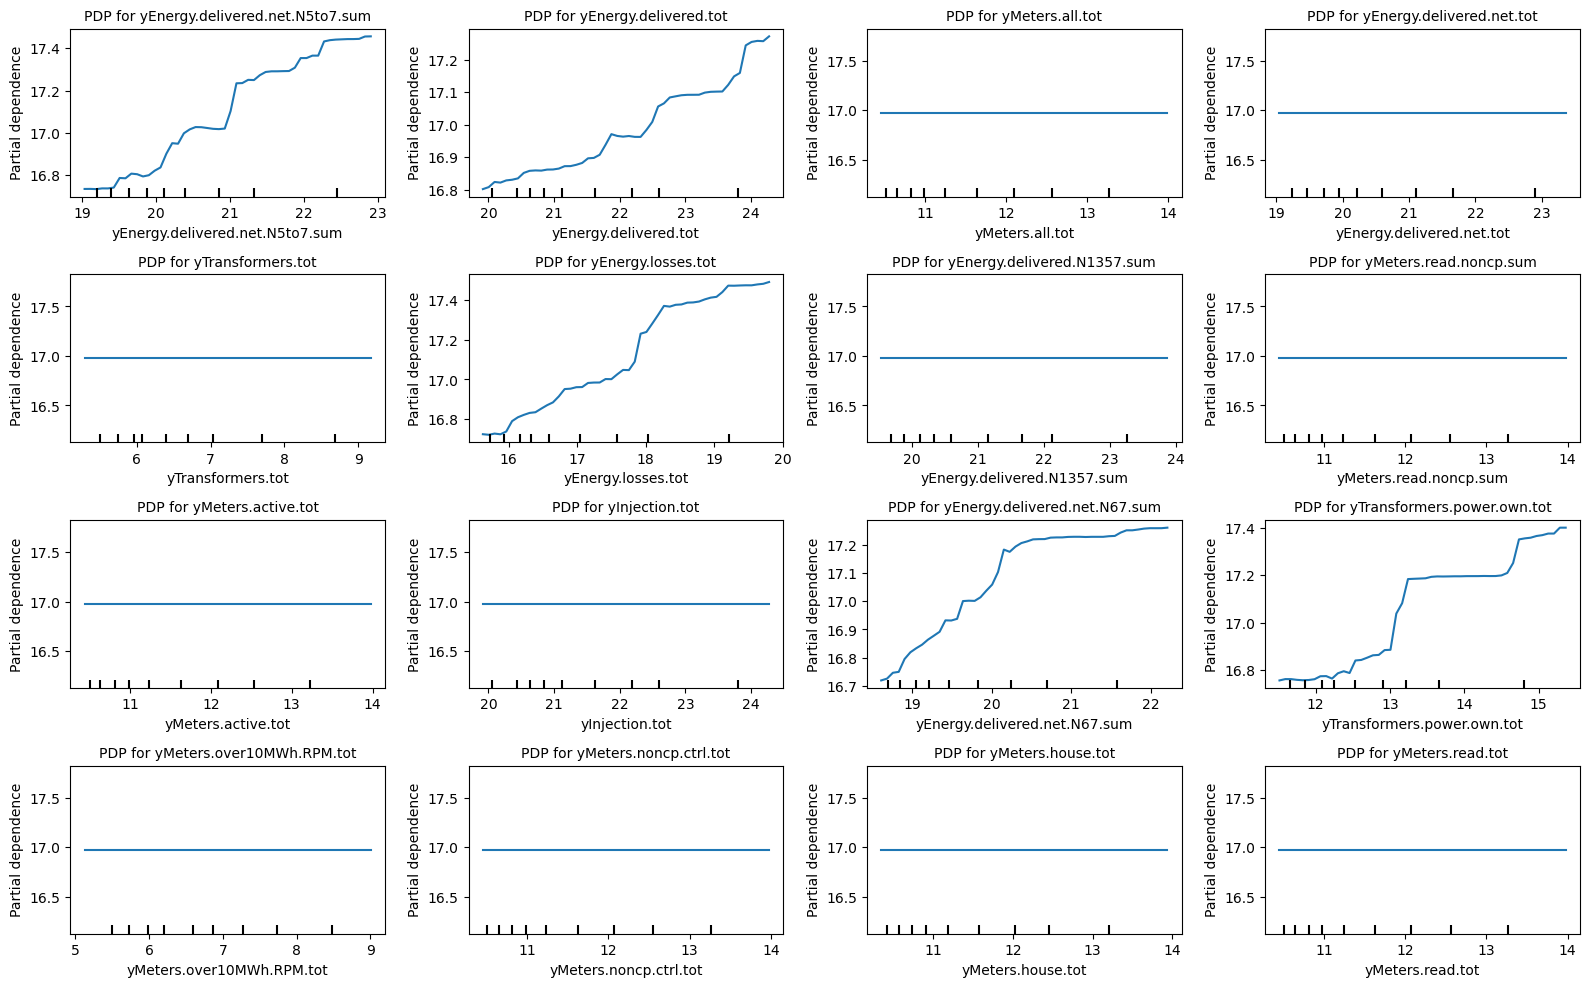

In [307]:
# Suppress specific warnings related to setting identical y-limits
warnings.filterwarnings("ignore", message="Attempting to set identical low and high ylims")

# Prepare the training data by excluding the target column
X_train = df_train.drop(columns=["cTOTEXn_log"])

# List of features excluding the empty placeholder columns
features = X_train.columns.tolist()
features = [feature for feature in features if feature not in ["empty_1", "empty_2", "empty_3", "empty_4"]]

# Set up the plot with a 5x4 grid of subplots
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 12))
ax = ax.flatten()  # Flatten the axes array for easy iteration

# Plot Partial Dependence Plot (PDP) for each feature
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        final_rf_agg_log_models[0],
        X_train,
        [feature],
        ax=ax[i],
        grid_resolution=50
    )
    ax[i].set_title(f'PDP for {feature}', fontsize=10)

# Remove any remaining unused axes
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Adjust layout and display the plots
plt.tight_layout() 
plt.show()

The Partial Dependence Plots (PDPs) for the features in the Random Forest Aggregates Only YLog model generally show an increasing trend, which implies a positive relationship between these features and the target variable (cTOTEXn_log). This aligns with the monotonicity constraints, where the expectation is that increases in certain features lead to an increase in the target variable.

However, it's important to note that PDPs have their limitations. Specifically, they show the marginal effect of a feature on the target variable, averaged over the distribution of other features. This means that while PDPs can indicate the direction and magnitude of a feature's influence, they do not provide direct regression coefficients or correlations, which are more concrete indicators of the sign and strength of relationships.

In summary, while the PDPs support the monotonic relationship for these features, they should be interpreted in conjunction with other statistical outputs, such as regression coefficients, to gain a fuller understanding of each feature's role in the model.

## **Decision Tree**

Running final Decision Tree regression on the Baseline model. The results are aggregated and models are ranked based on Testing MAPE.

In [43]:
# Initialize storage for final Decision Tree Baseline results, models, and VIPs
final_dt_baseline_results = pd.DataFrame(columns=columns)
final_dt_baseline_models = []
final_dt_baseline_vips = []

# Loop through each random state to prepare data and run Decision Tree regression
for random_state in random_states:
    # Prepare base training and testing datasets
    df_train, df_test = prepare_base_data(df, random_state=random_state)
    
    # Create variations of the datasets
    df_train_list, df_test_list = create_variations(df_train, df_test)

    # Focus on the Baseline model (index 0)
    i = 0
    selected_columns = list(dt_baseline_stable) + [outcome_variables[i]]
    
    # Due to max_features set in the model definition, fill up blank columns
    df_train = df_train_list[i].copy()[selected_columns]
    df_test = df_test_list[i].copy()[selected_columns]
    
    for index in range(18):
        df_train[f'empty_{index+1}'] = 0
        df_test[f'empty_{index+1}'] = 0

    # Perform Decision Tree regression and store the results
    dt_result, dt_model, dt_vip = decision_tree_regression(
        df_train, 
        df_test, 
        outcome_variables[i], 
        f"Decision Tree {names[i]}", 
        outcome_transformation=outcome_transformation[i], 
        random_state=random_state
    )
    final_dt_baseline_results = pd.concat([final_dt_baseline_results, dt_result], axis=0, ignore_index=True)
    final_dt_baseline_models.append(dt_model)
    final_dt_baseline_vips.append(dt_vip)

# Convert results to numeric, ignoring the 'Model' column
final_dt_baseline_results.loc[:, final_dt_baseline_results.columns != 'Model'] = final_dt_baseline_results.loc[:, final_dt_baseline_results.columns != 'Model'].apply(pd.to_numeric, errors='coerce')

# Aggregate results by model, compute the mean, and sort by 'Testing MAPE'
final_dt_baseline_results_df = final_dt_baseline_results.groupby(by="Model").mean().reset_index().sort_values(by="Testing MAPE")

# Display the final Decision Tree Baseline results DataFrame
final_dt_baseline_results_df


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Decision Tree Baseline,10761135.4580,2706912.9480,0.0420,37016309.6980,13266894.6720,0.2920


In [44]:
# Retrieve and display the parameters of the first Decision Tree Baseline model
final_dt_baseline_models[0].get_params()

{'memory': None,
 'steps': [('feature_selection',
   SelectFromModel(estimator=DecisionTreeRegressor(random_state=39),
                   max_features=20)),
  ('dt', DecisionTreeRegressor(max_depth=20, random_state=39))],
 'verbose': False,
 'feature_selection': SelectFromModel(estimator=DecisionTreeRegressor(random_state=39),
                 max_features=20),
 'dt': DecisionTreeRegressor(max_depth=20, random_state=39),
 'feature_selection__estimator__ccp_alpha': 0.0,
 'feature_selection__estimator__criterion': 'squared_error',
 'feature_selection__estimator__max_depth': None,
 'feature_selection__estimator__max_features': None,
 'feature_selection__estimator__max_leaf_nodes': None,
 'feature_selection__estimator__min_impurity_decrease': 0.0,
 'feature_selection__estimator__min_samples_leaf': 1,
 'feature_selection__estimator__min_samples_split': 2,
 'feature_selection__estimator__min_weight_fraction_leaf': 0.0,
 'feature_selection__estimator__random_state': 39,
 'feature_selection__e

The parameters of the first Decision Tree Baseline model indicate that the model is configured with a maximum depth of 20 and uses the "best" splitter to find the most effective splits. The feature selection step uses a `DecisionTreeRegressor` estimator to select a maximum of 20 features. The criterion for evaluating splits is the squared error, and the model employs standard settings for other hyperparameters such as `min_samples_split` and `min_samples_leaf`. The random state is set to 39 for reproducibility across both the feature selection and the decision tree steps.

### Visualizing Decision Tree Baseline model

Visualizing the structure of the first Decision Tree Baseline model, focusing on the top levels of the tree (up to a depth of 2). This plot illustrates how the model makes decisions based on the selected features.

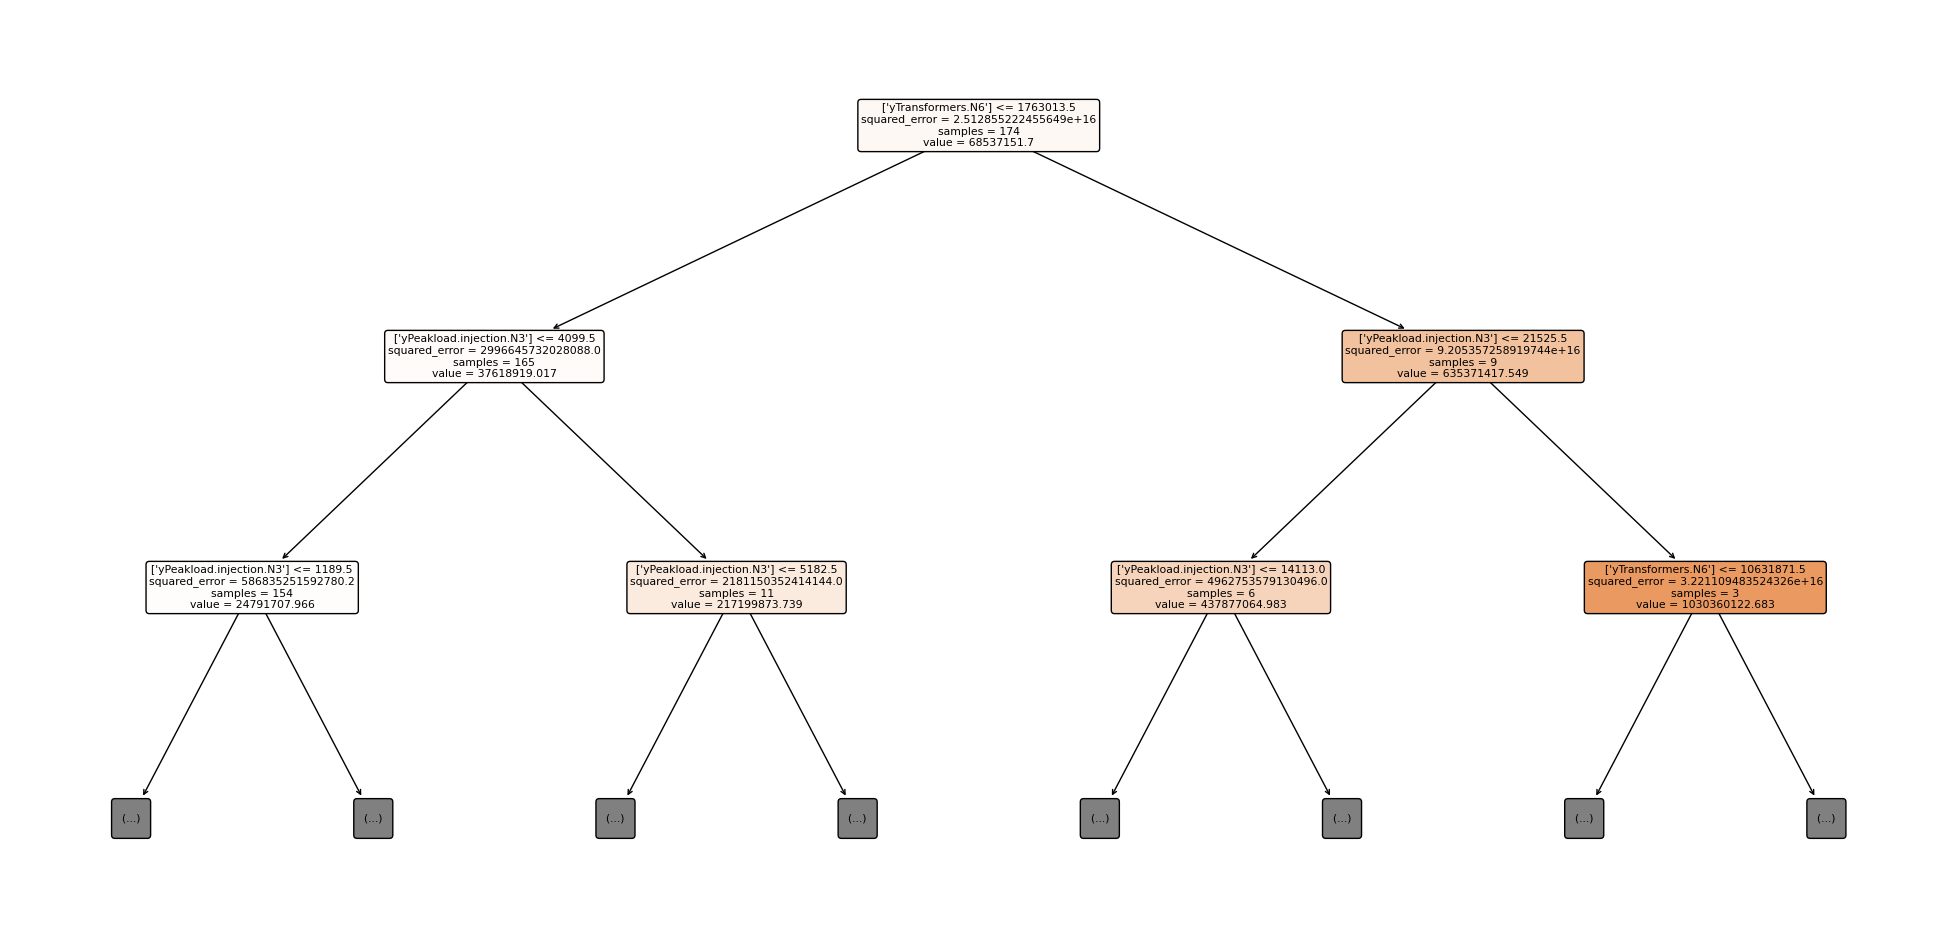

In [45]:
# Extract the Decision Tree model from the pipeline
decision_tree_model = final_dt_baseline_models[0].named_steps['dt']

# Plot the Decision Tree with a maximum depth of 2 for simplicity
plt.figure(figsize=(25, 12))  # Adjust the figure size for better readability
plot_tree(
    decision_tree_model, 
    filled=True, 
    feature_names=final_dt_baseline_vips[0][["Feature"]].values.tolist(), 
    rounded=True, 
    max_depth=2
)
plt.show()

The decision tree visualization shows `yPeakload.injection.N3` as the most important feature, driving the initial split in the model. Secondary splits involve `yTransformers.N6`, further refining predictions. This top-level view, capped at a depth of 2, reveals the key features that most significantly impact the model's prediction of `cTOTEXn_log`.

## **Summary Results**

In [49]:
# Combine the final results from Lasso, Linear Regression, Random Forest, and Decision Tree models
final_combined_all = pd.concat([
    final_lasso_xy_log_results_df, 
    final_lasso_agg_log_results_df, 
    final_lr_xy_log_results_df, 
    final_lr_agg_log_results_df, 
    final_rf_agg_log_results_df, 
    final_dt_baseline_results_df
], axis=0)

# Sort the combined results by Testing MAPE and Testing RMSE in ascending order
final_combined_all_sorted = final_combined_all.sort_values(by=["Testing MAPE", "Testing RMSE"], ascending=True)

# Display the sorted combined results
final_combined_all_sorted


,Model,Training RMSE,Training MAE,Training MAPE,Testing RMSE,Testing MAE,Testing MAPE
0,Linear Regression XLog YLog,17041001.7740,7086153.0540,0.1220,11235320.2080,5487740.7340,0.1260
0,Lasso XLog YLog,18722158.0020,7340288.0920,0.1260,9596175.5220,4991840.8700,0.1280
0,Linear Regression Aggregates Only YLog,16014603.3220,6681713.6860,0.1240,10090748.0360,5363045.3520,0.1320
0,Lasso Aggregates Only YLog,17808874.6440,7095395.6540,0.1260,10334888.5000,5419544.5340,0.1380
0,Random Forest Aggregates Only YLog,16906286.3260,4400815.3320,0.0600,29728127.4380,10183473.8060,0.1800
0,Decision Tree Baseline,10761135.4580,2706912.9480,0.0420,37016309.6980,13266894.6720,0.2920


The combined results show that the **Linear Regression XLog YLog** model has the best performance on the test set with a Testing MAPE of 0.126, followed closely by the **Lasso XLog YLog** model with a Testing MAPE of 0.128. The **Decision Tree Baseline** model exhibits the highest Testing MAPE of 0.292, indicating the largest deviation from the actual values on the test set. Notably, the **Random Forest Aggregates Only YLog** model also shows higher variability with a Testing MAPE of 0.180, reflecting potential overfitting or sensitivity to certain features.